In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker
from time import time as t
from numba import jit

import astropy.units as u
import astropy.constants as c

import photontools
import bokeh


### plt parameters

In [2]:
%matplotlib inline
# %matplotlib notebook

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.size"] = 15
plt.rcParams["figure.dpi"] = 72
# plt.rcParams["figure.dpi"] = 150
# plt.rcParams["figure.dpi"] = 300

lss = ['-', '--', '-.', ':']

In [3]:
bands_from_blue = np.array(["UVW2", "UVM2", "UVW1", "U", "B", "V", "R", "I", "J", "H", "K"])
# bands_from_blue = np.array(["UVW2", "UVM2", "UVW1", "U", "B", "V", "R", "I", "J"])
color_from_blue = np.array([plt.cm.jet(i/bands_from_blue.size) for i in range(bands_from_blue.size)])
dict_color = dict(zip(bands_from_blue, color_from_blue))

### run parameters

In [4]:
filepath_he = "../../hewd_hr//gamtmp.d"
# filepath_co = "../../cowd/gamtmp.d"
filepath_co = "../../cowd100x50x50/gamtmp.d"

directory_ML = "/Users/kawana/GoogleDrive/sync/study/yoshidalab/mypaper/0002_WD_TDE_radiation_transfer/WhiteDwarf_Thermonuclear_Transients/"
filepaths_spectra_ML = subprocess.getoutput('find "{}/WD06_spectra/" | grep ".par" | sort'.format(directory_ML)).split("\n")[1:]

vel_cowd = np.array([2.56466437e+03, 1.18143578e+04, -1.41779372e+00]) * 1e5
vel_hewd = np.array([4.49999438e+03, 1.54867843e+04, 1.27477734e+01]) * 1e5

# system = "Vega"
system = "AB"
# system = "ST"



In [6]:
# filters = photontools.read_all_filters()
# filterfilter_focas, filter_johnson, filter_ps, filter_swift, filter_twomass = filters

In [50]:
%time spectra_co = photontools.read_Maeda_data(filepath_co)

# binning 
%time spectra_co_reduced = spectra_co.binning(N_theta_bins=20, N_phi_bins=20, every_wavelength=5)

# Doppler shift
%time spectra_co_shifted = spectra_co_reduced.Doppler_shift_by_intrinsic_velocity(vel_cowd)


CPU times: user 5.46 s, sys: 10.4 s, total: 15.9 s
Wall time: 18.8 s
CPU times: user 6.04 s, sys: 4.01 s, total: 10.1 s
Wall time: 11.9 s
This Doppler shift only changes spectra.data!
Shift spectra.time later by yourself!
CPU times: user 770 ms, sys: 66.7 ms, total: 837 ms
Wall time: 870 ms


In [51]:
# system = "Vega"
system = "AB"
# system = "ST"


lc_co_bol     = spectra_co_shifted.calc_bolometric_luminosity().bolometric_luminosity_to_magnitude()
lc_co_focas   = photontools.calc_band_flux(spectra_co_shifted, filters[0]).convert_flux_to_magnitude(filters[0], system=system)
lc_co_john    = photontools.calc_band_flux(spectra_co_shifted, filters[1]).convert_flux_to_magnitude(filters[1], system=system)
# lc_co_ps      = photontools.calc_band_flux(spectra_co_shifted, filters[2]).convert_flux_to_magnitude(filters[2], system=system)
lc_co_swift   = photontools.calc_band_flux(spectra_co_shifted, filters[3]).convert_flux_to_magnitude(filters[3], system=system)
lc_co_twomass = photontools.calc_band_flux(spectra_co_shifted, filters[4]).convert_flux_to_magnitude(filters[4], system=system)


/Users/kawana/GoogleDrive/sync/study/yoshidalab/tidal_disruption/imbh-wd/nuclear/std/compare/snaps/successed/photons/analysis/python/photontools/photontools.py:583: RuntimeWarning: divide by zero encountered in log10
  new_lc.data  = -2.5 * np.log10(self.data[:,:,:] / c.L_bol0.cgs.value)
/Users/kawana/GoogleDrive/sync/study/yoshidalab/tidal_disruption/imbh-wd/nuclear/std/compare/snaps/successed/photons/analysis/python/photontools/photontools.py:620: RuntimeWarning: divide by zero encountered in log10
  new_lc.data = -2.5 * np.log10(self.data / flux_zero_lambda / (4 * np.pi * distance.to(u.cm).value **2))
/Users/kawana/GoogleDrive/sync/study/yoshidalab/tidal_disruption/imbh-wd/nuclear/std/compare/snaps/successed/photons/analysis/python/photontools/photontools.py:620: RuntimeWarning: invalid value encountered in log10
  new_lc.data = -2.5 * np.log10(self.data / flux_zero_lambda / (4 * np.pi * distance.to(u.cm).value **2))
/Users/kawana/GoogleDrive/sync/study/yoshidalab/tidal_disruption/i

# mean lightcurve over theta and phi

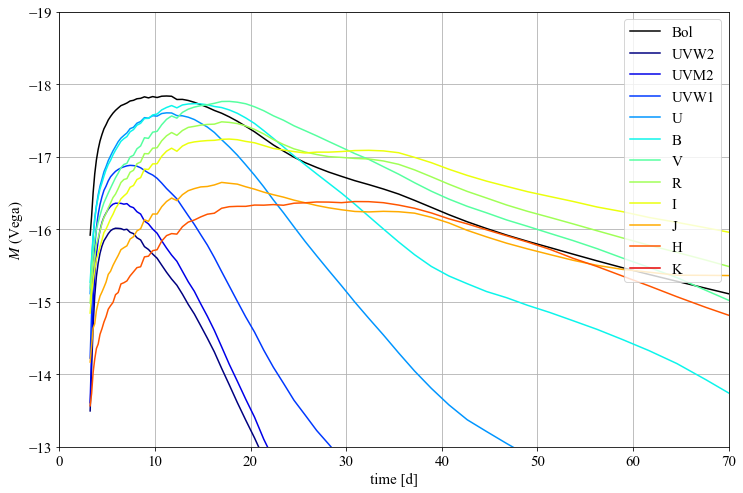

In [14]:
i_time_st=0

plt.figure(figsize=(12,8))

plt.plot(lc_co_bol.times[i_time_st:], lc_co_bol.data[i_time_st:,:,:].mean(axis=(1,2)), label="Bol", color="black")
# swift
list_index_bands = np.argsort(filter_swift.effective_wavelength)
for i in list_index_bands[:3]:
    band = lc_co_swift.bands[i]
    plt.plot(lc_co_swift.times, lc_co_swift.data[i_time_st:,:,:,i].mean(axis=(1,2)), 
             label=band,
             color=dict_color[band])

#johnson
list_index_bands = np.argsort(filter_johnson.effective_wavelength)
for i in list_index_bands:
    band = lc_co_john.bands[i][0]
    plt.plot(lc_co_john.times, lc_co_john.data[i_time_st:,:,:,i].mean(axis=(1,2)), 
             label=band,
             color=dict_color[band])

#twomass
list_index_bands = np.argsort(filter_twomass.effective_wavelength)
for i in list_index_bands:
    band = lc_co_twomass.bands[i][0].capitalize()
    plt.plot(lc_co_twomass.times, lc_co_twomass.data[i_time_st:,:,:,i].mean(axis=(1,2)), 
             label=band,
             color=dict_color[band])

plt.legend()



# plt.title("MacLeod")
plt.xlabel("time [d]")
plt.ylabel(r"$M$ (Vega)")
plt.xlim(0,70)
plt.ylim(-19,-13)
plt.grid()
plt.gca().invert_yaxis()
# plt.title("solid: High resolution, dotted: Low resolution, dashed: MacLeod")
# plt.title("solid: High resolution, dotted: Low resolution")
# plt.legend()
# plt.savefig("figs/cowd/lc_compare_resolution.png")


## Superposition of lightcurve over all the angle

In [20]:
list_index_bands

array([3, 0, 4, 2, 1])

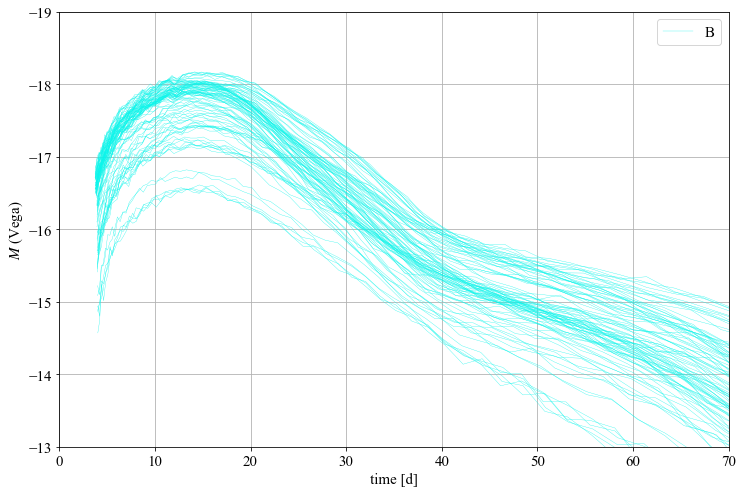

In [22]:
i_time_st=4
ckeys={"alpha":1, "linewidth":0.3}

plt.figure(figsize=(12,8))

first=True
for j in range(lc_co_bol.thetas.size):
    for k in range(lc_co_bol.phis.size):
        
#         plt.plot(lc_co_bol.times[i_time_st:] / lc_co_bol.Doppler_shift_intrinsic[j,k], lc_co_bol.data[i_time_st:,j,k], label="Bol", color="black", **ckeys)
#         # swift
#         list_index_bands = np.argsort(filter_swift.effective_wavelength)
#         for i in list_index_bands[:3]:
#             band = lc_co_swift.bands[i]
#             plt.plot(lc_co_swift.times[i_time_st:] / lc_co_bol.Doppler_shift_intrinsic[j,k], lc_co_swift.data[i_time_st:,j,k,i], 
#                      label=band,
#                      color=dict_color[band],
#                     **ckeys)

#         #johnson
        list_index_bands = np.argsort(filter_johnson.effective_wavelength)
        for i in list_index_bands:
            if (i==0):
                band = lc_co_john.bands[i][0]
                plt.plot(lc_co_john.times[i_time_st:] / lc_co_bol.Doppler_shift_intrinsic[j,k], lc_co_john.data[i_time_st:,j,k,i], 
                         label=band,
                         color=dict_color[band],
                        **ckeys)

#         #twomass
#         list_index_bands = np.argsort(filter_twomass.effective_wavelength)
#         for i in list_index_bands:
#             band = lc_co_twomass.bands[i][0].capitalize()
#             plt.plot(lc_co_twomass.times[i_time_st:] / lc_co_bol.Doppler_shift_intrinsic[j,k], lc_co_twomass.data[i_time_st:,j,k,i], 
#                      label=band,
#                      color=dict_color[band],
#                     **ckeys)
        
        if(first):
            plt.legend()
            first=False



# plt.title("MacLeod")
plt.xlabel("time [d]")
plt.ylabel(r"$M$ (Vega)")
plt.xlim(0,70)
plt.ylim(-19,-13)
plt.grid()
plt.gca().invert_yaxis()
# plt.title("solid: High resolution, dotted: Low resolution, dashed: MacLeod")
# plt.title("solid: High resolution, dotted: Low resolution")
# plt.legend()
# plt.savefig("figs/cowd/lc_compare_resolution.png")


# He WD

In [62]:
%time spectra_he = photontools.read_Maeda_data(filepath_he)

%time spectra_he_reduced = spectra_he.binning(N_theta_bins=20, N_phi_bins=20, every_wavelength=1)

# Doppler shift
%time spectra_he_shifted = spectra_he_reduced.Doppler_shift_by_intrinsic_velocity(vel_hewd)

# binning 
# %time spectra_reduced = spectra_shifted.binning(N_theta_bins=10, N_phi_bins=10, every_wavelength=1)

CPU times: user 6.85 s, sys: 14 s, total: 20.8 s
Wall time: 25.8 s
CPU times: user 6.79 s, sys: 3.57 s, total: 10.4 s
Wall time: 12.6 s
This Doppler shift only changes spectra.data!
Shift spectra.time later by yourself!
CPU times: user 7.11 s, sys: 634 ms, total: 7.75 s
Wall time: 8.97 s


In [63]:
# system = "Vega"
system = "AB"
# system = "ST"


lc_he_bol     = spectra_he_shifted.calc_bolometric_luminosity().bolometric_luminosity_to_magnitude()
lc_he_focas   = photontools.calc_band_flux(spectra_he_shifted, filters[0]).convert_flux_to_magnitude(filters[0], system=system)
lc_he_john    = photontools.calc_band_flux(spectra_he_shifted, filters[1]).convert_flux_to_magnitude(filters[1], system=system)
# lc_he_ps      = photontools.calc_band_flux(spectra_he_shifted, filters[2]).convert_flux_to_magnitude(filters[2], system=system)
lc_he_swift   = photontools.calc_band_flux(spectra_he_shifted, filters[3]).convert_flux_to_magnitude(filters[3], system=system)
lc_he_twomass = photontools.calc_band_flux(spectra_he_shifted, filters[4]).convert_flux_to_magnitude(filters[4], system=system)


/Users/kawana/GoogleDrive/sync/study/yoshidalab/tidal_disruption/imbh-wd/nuclear/std/compare/snaps/successed/photons/analysis/python/photontools/photontools.py:583: RuntimeWarning: divide by zero encountered in log10
  new_lc.data  = -2.5 * np.log10(self.data[:,:,:] / c.L_bol0.cgs.value)
/Users/kawana/GoogleDrive/sync/study/yoshidalab/tidal_disruption/imbh-wd/nuclear/std/compare/snaps/successed/photons/analysis/python/photontools/photontools.py:620: RuntimeWarning: divide by zero encountered in log10
  new_lc.data = -2.5 * np.log10(self.data / flux_zero_lambda / (4 * np.pi * distance.to(u.cm).value **2))
/Users/kawana/GoogleDrive/sync/study/yoshidalab/tidal_disruption/imbh-wd/nuclear/std/compare/snaps/successed/photons/analysis/python/photontools/photontools.py:620: RuntimeWarning: invalid value encountered in log10
  new_lc.data = -2.5 * np.log10(self.data / flux_zero_lambda / (4 * np.pi * distance.to(u.cm).value **2))
/Users/kawana/GoogleDrive/sync/study/yoshidalab/tidal_disruption/i

In [92]:
# i_time_st = 14
i_time_st = 4

lc_bol_ = lc_he_bol[i_time_st:]


mask_Bband = np.array([band[0] == "B" for band in filter_johnson.bands])
lc_B_ = lc_he_john[i_time_st:,:,:,mask_Bband]

peak_mag = np.zeros((lc_bol_.thetas.size, lc_bol_.phis.size), dtype=np.float)
t_peak = np.zeros((lc_bol_.thetas.size, lc_bol_.phis.size), dtype=np.float)
t_1mag = np.zeros((lc_bol_.thetas.size, lc_bol_.phis.size), dtype=np.float)
delta_t_1mag = np.zeros((lc_bol_.thetas.size, lc_bol_.phis.size), dtype=np.float)

t_B_peak = np.zeros((lc_B_.thetas.size, lc_B_.phis.size), dtype=np.float)
M_B_peak = np.zeros((lc_B_.thetas.size, lc_B_.phis.size), dtype=np.float)
delta_m15 = np.zeros((lc_B_.thetas.size, lc_B_.phis.size), dtype=np.float)

indexes_time_peak = lc_bol_.data.argmin(axis=(0))
indexes_B_peak = lc_B_.data.argmin(axis=(0))

for i in range(lc_bol_.thetas.size):
    for j in range(lc_bol_.phis.size):
        t_peak[i,j]    = lc_bol_.times[indexes_time_peak[i][j]]
        peak_mag[i,j]  = lc_bol_.data[indexes_time_peak[i][j], i, j]
        t_B_peak[i,j]  = lc_B_.times[indexes_time_peak[i][j]]
        M_B_peak[i,j]  = lc_B_.data[indexes_B_peak[i][j], i, j]
#         delta_m15[i,j] = np.interp(15 / lc_B_.Doppler_shift_intrinsic[i,j], lc_B_.times - t_peak[i,j], lc_B_.data[:,i,j,0]) - lc_B_.data[indexes_time_peak[i,j],i,j,0]
        delta_m15[i,j] = np.interp(10 / lc_B_.Doppler_shift_intrinsic[i,j], lc_B_.times - lc_B_.times[indexes_B_peak[i,j]], lc_B_.data[:,i,j,0]) - lc_B_.data[indexes_B_peak[i,j],i,j,0]


index_time_1mag = np.argmin(np.abs(1 + np.tile(peak_mag, (lc_bol_.data.shape[0], 1, 1)) - lc_bol_.data), axis=0)

for i in range(lc_bol_.thetas.size):
    for j in range(lc_bol_.phis.size):
        t_1mag[i,j] = lc_bol_.times[index_time_1mag[i,j]]
t_1mag = t_1mag / (spectra_he_shifted.Doppler_shift_intrinsic)
t_peak = t_peak / (spectra_he_shifted.Doppler_shift_intrinsic)
delta_t_1mag = t_1mag - t_peak

In [65]:
# delta_m15_he = delta_m15
# M_B_peak_he = M_B_peak

# delta_m15_co = delta_m15
# M_B_peak_co = M_B_peak

In [ ]:
delta_m10_B = delta_m15

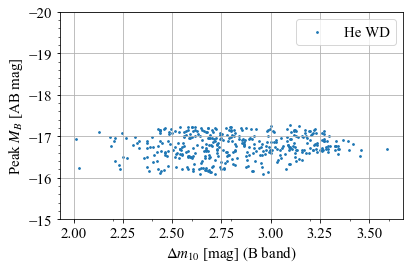

In [94]:
fig=plt.figure()
plt.scatter(delta_m15, M_B_peak, label="He WD", s=3)
# plt.scatter(delta_m15_co, M_B_peak_co, label="CO WD", s=3)
# plt.xlim(0.8, 2.2)
plt.ylim(-20,-15)
ax = plt.gca()
ax.invert_yaxis()
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.2))
plt.grid()
# plt.grid()
plt.xlabel(r"$\Delta m_{10}$ [mag] (B band)")
plt.ylabel(r"Peak $M_B$ [AB mag]")
plt.legend()
fig.tight_layout()
# plt.savefig("figs/Phillips_relation_10d_Bband.pdf", dpi=300, transparent=True)
plt.show()

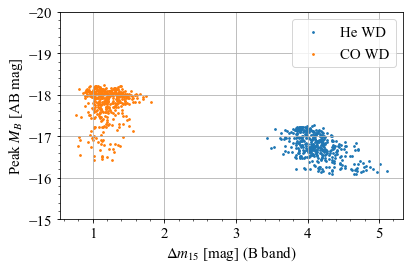

In [91]:
fig=plt.figure()
plt.scatter(delta_m15_he, M_B_peak_he, label="He WD", s=3)
plt.scatter(delta_m15_co, M_B_peak_co, label="CO WD", s=3)
# plt.xlim(0.8, 2.2)
plt.ylim(-20,-15)
ax = plt.gca()
ax.invert_yaxis()
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.2))
plt.grid()
# plt.grid()
plt.xlabel(r"$\Delta m_{15}$ [mag] (B band)")
plt.ylabel(r"Peak $M_B$ [AB mag]")
plt.legend()
fig.tight_layout()
# plt.savefig("figs/Phillips_relation.pdf", dpi=300, transparent=True)
plt.show()

In [15]:
fig = plt.figure()
plt.scatter(np.log10(delta_t_1mag_he), np.log10(c.L_bol0.cgs.value * 10 ** (-0.4 * peak_mag_he)), label="He WD")
plt.scatter(np.log10(delta_t_1mag), np.log10(c.L_bol0.cgs.value * 10 ** (-0.4 * peak_mag)), label="CO WD")
plt.ylabel(r"$\log$ ($L_{\rm bol}$ [erg/s])")
plt.xlabel(r"$\Delta t_{\rm 1 mag}$ [d]")
plt.grid()
plt.legend()
fig.tight_layout()
# plt.savefig("figs/time_luminosity.pdf", dpi=300, transparent=True)
plt.show()

NameError: name 'delta_t_1mag_he' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(lc_maeda_john.times, lc_maeda_john.data[:,:,:,0].mean(axis=(1,2)) - lc_maeda_john.data[:,:,:,4].mean(axis=(1,2)))



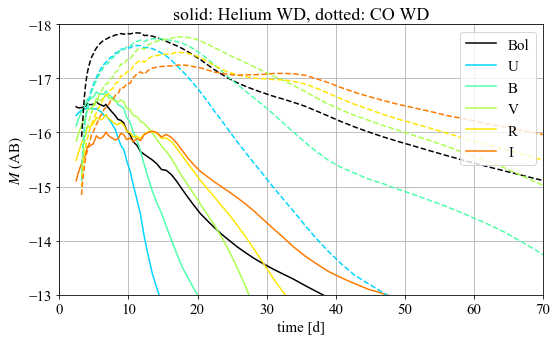

In [333]:
i_time = 9
j_theta=0
j_theta_ed=1
k_phi=0
k_phi_ed=1

ckeys = {"ls":lss[0]}


fig = plt.figure(figsize=(8,5))

plt.plot(lc_maeda_bol.times[i_time:], lc_maeda_bol.data[i_time:,j_theta:j_theta_ed,k_phi:k_phi_ed].mean(axis=(1,2)), label="Bol", color="black",
        **ckeys
        )
# swift
# list_index_bands = np.argsort(filter_swift.effective_wavelength)
# for i in list_index_bands[:3]:
#     band = lc_maeda_swift.bands[i]
#     plt.plot(lc_maeda_swift.times[i_time:], lc_maeda_swift.data[i_time:,j_theta:j_theta_ed,k_phi:k_phi_ed,i].mean(axis=(1,2)), 
#              label=band,
#              color=dict_color[band],
#              **ckeys
#             )

#johnson
list_index_bands = np.argsort(filter_johnson.effective_wavelength)
for i in list_index_bands:
    band = lc_maeda_john.bands[i][0]
    plt.plot(lc_maeda_john.times[i_time:], lc_maeda_john.data[i_time:,j_theta:j_theta_ed,k_phi:k_phi_ed,i].mean(axis=(1,2)),
             label=band,
             color=dict_color[band],
             **ckeys
             )

# #twomass
# list_index_bands = np.argsort(filter_twomass.effective_wavelength)
# for i in list_index_bands:
#     band = lc_maeda_twomass.bands[i][0].capitalize()
#     if(band == "J"):
#         plt.plot(lc_maeda_twomass.times[i_time:], lc_maeda_twomass.data[i_time:,j_theta:j_theta_ed,k_phi:k_phi_ed,i].mean(axis=(1,2)), 
#                  label=band,
#                  color=dict_color[band])

plt.legend()


ckeys = {"ls":lss[1]}


plt.plot(lc_maeda_high_bol.times, lc_maeda_high_bol.data[:,:,:].mean(axis=(1,2)), label="Bol", color="black", **ckeys)
# swift
# list_index_bands = np.argsort(filter_swift.effective_wavelength)
# for i in list_index_bands[:3]:
#     band = lc_maeda_high_swift.bands[i]
#     plt.plot(lc_maeda_high_swift.times, lc_maeda_high_swift.data[:,:,:,i].mean(axis=(1,2)),
#              label=band,
#              color=dict_color[band],
#              **ckeys
#             )

#johnson
list_index_bands = np.argsort(filter_johnson.effective_wavelength)
for i in list_index_bands:
    band = lc_maeda_high_john.bands[i][0]
    plt.plot(lc_maeda_high_john.times, lc_maeda_high_john.data[:,:,:,i].mean(axis=(1,2)), 
             label=band,
             color=dict_color[band],
             **ckeys
            )

#twomass
# list_index_bands = np.argsort(filter_twomass.effective_wavelength)
# for i in list_index_bands:
#     band = lc_maeda_high_twomass.bands[i][0].capitalize()
#     if(band == "J"):
#         plt.plot(lc_maeda_high_twomass.times, lc_maeda_high_twomass.data[:,:,:,i].mean(axis=(1,2)), 
#                  label=band,
#                  color=dict_color[band],
#                  **ckeys
#                 )


    
# plt.title("MacLeod")
plt.xlabel("time [d]")
plt.ylabel(r"$M$ (AB)")
plt.xlim(0,70)
plt.ylim(-18,-13)
plt.grid()
plt.gca().invert_yaxis()
plt.title("solid: Helium WD, dotted: CO WD")
# plt.legend()
fig.tight_layout()
plt.savefig("figs/lc_mean_AB_compare_CO_He.pdf", dpi=300, transparent=True)
plt.show()
plt.close()

In [221]:
%time spectra_reduced = spectra_shifted.binning(N_theta_bins=20, N_phi_bins=20, every_wavelength=1)

lc_maeda_bol     = spectra_reduced.calc_bolometric_luminosity()



CPU times: user 6.59 s, sys: 3.99 s, total: 10.6 s
Wall time: 13.5 s


0 0.9833208358931959
1 0.9720587791614216
2 0.9714823126688336
3 0.9818116270222249
4 0.9991012752190822
5 1.0167471993017343
6 1.0280092560335086
7 1.0285857225260968
8 1.0182564081727055
9 1.000966759975848
10 nan
11 nan
12 nan
13 nan
14 nan
15 nan
16 nan
17 nan
18 nan
19 nan


/Users/kawana/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: Mean of empty slice.
/Users/kawana/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: Mean of empty slice.


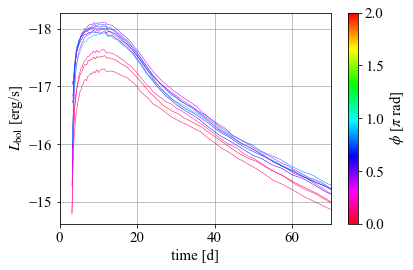

In [397]:
mycolor=plt.cm.hsv_r
i_time=0
i_time_ed=-2
k_phi=0
k_phi_ed=20
j_theta=8
j_theta_ed = 12
every_phi = 1
keys_line ={"linewidth":0.5}


# fig = plt.figure(figsize=(16,8))
fig = plt.figure(figsize=(6,4))
ax = plt.gca()

for k_phi in np.arange(0, spectra_.phis.size, every_phi):
    k_phi_ed = k_phi + every_phi
    offset_ = - 0.015e39
    offset_2 = 20 * offset_
    offset_2 = 0
#     offset_ = 0
    print(k_phi, spectra_reduced.Doppler_shift_intrinsic[j_theta:j_theta_ed,k_phi:k_phi_ed].mean(axis=(0,1)))
    plt.plot(lc_maeda_high_bol.times[i_time:i_time_ed] * spectra_reduced_high.Doppler_shift_intrinsic[j_theta:j_theta_ed,k_phi:k_phi_ed].mean(axis=(0,1)), lc_maeda_high_bol.data[i_time:i_time_ed,j_theta:j_theta_ed,k_phi:k_phi_ed].mean(axis=(1,2)), label="Bol", 
             color=mycolor(k_phi / spectra_.phis.size), **keys_line)

sm = plt.cm.ScalarMappable(cmap=mycolor, norm=colors.Normalize(vmin=0, vmax=2))
sm._A = []
cb = plt.colorbar(sm,label=r'$\phi$ [$\pi$ rad]',orientation='vertical',shrink=1.0)

plt.xlim(0, 70)


plt.xlabel("time [d]")
plt.ylabel(r"$L_{\rm bol}$ [erg/s]")

plt.gca().invert_yaxis()
plt.grid()
# plt.title(r"Ca II IR triplet, $\lambda_{\rm center} = 8600 \AA$")
# plt.legend(loc="best")
fig.tight_layout()
# plt.savefig("figs/hewd/lc_bol_angle_orbital_plane.pdf".format(spectra_.times.mean()), dpi=300, transparent=True)
# plt.savefig("figs/hewd/spectra_wo_Doppler_shift_all_angle2.pdf", dpi=300, transparent=True)

plt.show()



# SPH

# Abundance

In [8]:
sph_data_total = pd.read_pickle("/Users/kawana/GoogleDrive/sync/study/yoshidalab/tidal_disruption/imbh-wd/nuclear/std/compare/snaps/successed/snap_bh3.16e+02_wd0.20_beta05.0_00786432_he_irirt05_pot2_nuc1/sph_calc_t9999.pickle")
sph_data_unbound = pd.read_pickle("/Users/kawana/GoogleDrive/sync/study/yoshidalab/tidal_disruption/imbh-wd/nuclear/std/compare/snaps/successed/snap_bh3.16e+02_wd0.20_beta05.0_00786432_he_irirt05_pot2_nuc1/sph_calc_t9999_unbound.pickle")

# sph_data_total = pd.read_pickle("/Users/kawana/GoogleDrive/sync/study/yoshidalab/tidal_disruption/imbh-wd/nuclear/std/compare/snaps/successed/snap_bh5.00e+02_wd0.60_beta05.0_00393216_co_irirt05_pot0_nuc1_tot/sph_t1000_c136.pickle")
# sph_data_unbound = sph_data_total[sph_data_total["c100"]==4]

In [9]:
mass_ = sph_data_unbound["c3"].iloc[0]
mass_aprox13 = (mass_ * u.g / c.M_sun * sph_data_unbound[sph_data_unbound.columns[31:44]].sum()).cgs.value
mass_stable  = (mass_ * u.g / c.M_sun * sph_data_unbound[sph_data_unbound.columns[65:95]].sum()).cgs.value
mass_active  = (mass_ * u.g / c.M_sun * sph_data_unbound[sph_data_unbound.columns[95:99]].sum()).cgs.value

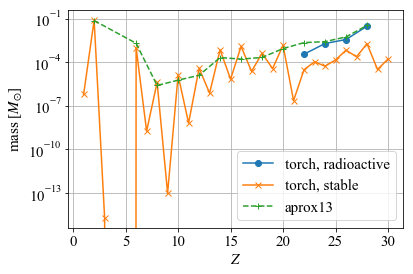

In [10]:
fig = plt.figure(figsize=(6,4))
plt.semilogy(np.arange(22, 30, 2), mass_active, marker="o", label="torch, radioactive")
plt.semilogy(np.arange(1, 31, 1), mass_stable, marker="x", label="torch, stable")
plt.semilogy(np.append([2], np.arange(6, 30, 2, dtype=int)), mass_aprox13, linestyle=lss[1], marker="+", label="aprox13")
plt.legend()
# plt.ylim(1e-9,0.3)
# plt.ylim(1e-7,0.1)
plt.xlabel(r"$Z$")
plt.ylabel(r"mass [$M_{\odot}$]")
plt.grid()
# plt.savefig("figs/cowd/abundance_log.pdf", dpi=300, transparent=True)
plt.show()


# snapshot

<Figure size 576x288 with 0 Axes>

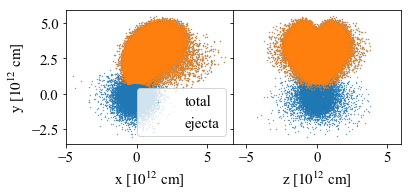

In [11]:
ckeys = {"s":0.1, "marker":"o"}

fig = plt.figure(figsize=(8,4))
fig, axes = plt.subplots(1,2, sharey =True)

# lim1 = [-4.5,6.5]
# lim2 = [-3.2,5.8]
# lim3 = [-4.5,4.]

# gskw = dict(width_ratios = [np.diff(lim1)[0],np.diff(lim3)[0]])

# gs = matplotlib.gridspec.GridSpec(1,2, **gskw)

# fig = plt.figurere(figsize=(10,5))


ax = axes[0]
# ax=fig.add_subplot(gs[0], aspect="equal",adjustable='box-forced')

x_ = sph_data_total["c4"] / 1e12
y_ = sph_data_total["c5"] / 1e12
ax.scatter(x_, y_, color="C0", label = "total", **ckeys)
x_ = sph_data_unbound["c4"] / 1e12
y_ = sph_data_unbound["c5"] / 1e12
ax.scatter(x_, y_, color="C1", label = "ejecta", **ckeys)

ax.set_xlabel(r"x [$10^{12}$ cm]")
ax.set_ylabel(r"y [$10^{12}$ cm]")
ax.set_aspect("equal")
# ax.grid()
ax.legend(loc="best")
x_min, x_max = ax.get_xlim()
width = x_max - x_min
# ax1 = ax

# ax=fig.add_subplot(gs[1], aspect="equal",adjustable='box-forced', sharey=ax1)


ax = axes[1]
y_ = sph_data_total["c5"] / 1e12
x_ = sph_data_total["c6"] / 1e12
ax.scatter(x_, y_, color="C0", **ckeys)
y_ = sph_data_unbound["c5"] / 1e12
x_ = sph_data_unbound["c6"] / 1e12
ax.scatter(x_, y_, color="C1", **ckeys)

ax.set_xlabel(r"z [$10^{12}$ cm]")
# plt.ylabel(r"y [$10^{12}$ cm]")
ax.set_aspect("equal")
# ax.grid()
ax.set_xlim(-0.5 * width, 0.5 * width)
fig.subplots_adjust(wspace=0)
# plt.savefig("figs/hewd/particle_distribution.png", dpi=300, transparent=True)
plt.show()
plt.close()


# comparison with mesh

In [17]:
import mesh
import seaborn as sns

In [8]:
mesh_ = mesh.read_mesh_data("/Users/kawana/GoogleDrive/sync/study/yoshidalab/tidal_disruption/imbh-wd/nuclear/std/compare/snaps/successed/snap_bh3.16e+02_wd0.20_beta05.0_00786432_he_irirt05_pot2_nuc1/mesh_calc_t9999_unbound_Nr100_Ntheta50_Nphi50_ri0.00e+00_rf4.00e+12_omp40.dat")

In [9]:
X_r = (np.sum(mesh_.data[:,:,:,15:].swapaxes(3,2).swapaxes(2,1).swapaxes(1,0) * mesh_.data[:,:,:,14], axis=(2,3)) / np.sum(mesh_.data[:,:,:,14], axis=(1,2))).swapaxes(0,1)
# shape
# .swapaxes(1,0).swapaxes(2,1).swapaxes(3,2).shape

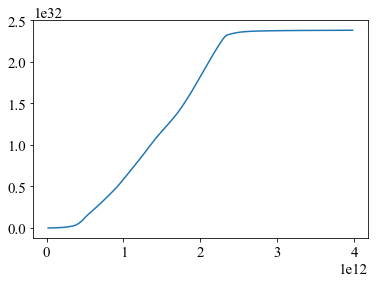

In [12]:
plt.plot(mesh_.radius, mesh_.mass)

In [19]:
mesh.Mesh?

In [20]:
np.array([34, 38, 40, 42, 44, 46, 48, 52]) - 5

array([29, 33, 35, 37, 39, 41, 43, 47])

In [23]:
X_r.shape

(100, 47)

In [25]:
np.array([29, 33, 35, 37, 39, 41, 43, 47, 58, 59, 60, 61]) - 15

array([14, 18, 20, 22, 24, 26, 28, 32, 43, 44, 45, 46])

In [36]:
lss * 4

['-',
 '--',
 '-.',
 ':',
 '-',
 '--',
 '-.',
 ':',
 '-',
 '--',
 '-.',
 ':',
 '-',
 '--',
 '-.',
 ':']

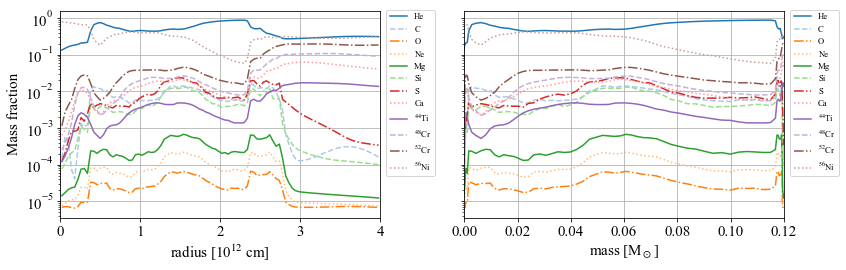

In [43]:
labels_ = np.array(["He", "C", "O", "Ne", "Mg", "Si", "S", "Ca", r"$^{44}$Ti", r"$^{48}$Cr", r"$^{52}$Cr", r"$^{56}$Ni"])
indexes_ = np.array([14, 18, 20, 22, 24, 26, 28, 32, 43, 44, 45, 46])
colors_ = sns.color_palette("tab20", labels_.size)
lss_ = lss * 4

fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True)
# fig.figsize=((18,6))
ax = axes[0]
for i, j in enumerate(indexes_):
    ax.semilogy(mesh_.radius * 1e-12, X_r[:,j], label=labels_[i], color=colors_[i], ls=lss_[i])
ax.set_xlim(0, 4)
ax.set_xlabel(r"radius [10$^{12}$ cm]")
ax.set_ylabel("Mass fraction")
ax.grid()
ax.legend(fontsize="xx-small", loc=(1.02,0.2))

ax = axes[1]
for i, j in enumerate(indexes_):
    ax.semilogy(mesh_.mass / c.M_sun.cgs, X_r[:,j], label=labels_[i], color=colors_[i], ls=lss_[i])
ax.set_xlim(0, 0.12)
ax.set_xlabel(r"mass [M$_\odot$]")
ax.grid()
ax.legend(fontsize="xx-small", loc=(1.02,0.2))


fig.tight_layout()
# plt.savefig("figs/hewd/abundance_distribution2.png", dpi=300, transparent=True)
plt.show()
plt.close()


In [16]:
len(labels_)

11

In [89]:
M_r

array([2.68534083e+27, 2.03036406e+28, 6.03210138e+28, 1.23227720e+29,
       2.02614878e+29, 2.93308584e+29, 4.02508881e+29, 5.24457578e+29,
       6.55045928e+29, 1.12862453e+30, 2.17394802e+30, 3.03742082e+30,
       3.92157206e+30, 3.59029831e+30, 3.27282088e+30, 3.34529965e+30,
       3.28998857e+30, 3.40537633e+30, 3.59398716e+30, 3.61624543e+30,
       3.64542517e+30, 3.70373644e+30, 3.84809875e+30, 4.12620089e+30,
       4.38889618e+30, 4.53696999e+30, 4.58904578e+30, 4.58866863e+30,
       4.61329334e+30, 4.61683057e+30, 4.63039884e+30, 4.73123135e+30,
       4.86848418e+30, 4.85518409e+30, 4.81840718e+30, 4.68541299e+30,
       4.38748844e+30, 4.25502240e+30, 4.15459912e+30, 4.16860756e+30,
       4.30181904e+30, 4.41364717e+30, 4.69277631e+30, 5.04053347e+30,
       5.43125773e+30, 5.66567407e+30, 5.90171789e+30, 6.09848886e+30,
       6.36150895e+30, 6.45577152e+30, 6.39651805e+30, 6.41500381e+30,
       6.42009895e+30, 6.41893564e+30, 6.29826014e+30, 5.98654153e+30,
      

In [61]:
np.sum(mesh_.data[:,:,:,14].swapaxes(3,2).swapaxes(2,1).swapaxes(1,0) * mesh_.data[:,:,:,15:], axis=(1,2))

AxisError: axis1: axis 3 is out of bounds for array of dimension 3

In [47]:
b_[0,:,:,0]

array([[0.000e+00, 1.000e+00, 2.000e+00, ..., 4.700e+01, 4.800e+01,
        4.900e+01],
       [5.000e+01, 5.100e+01, 5.200e+01, ..., 9.700e+01, 9.800e+01,
        9.900e+01],
       [1.000e+02, 1.010e+02, 1.020e+02, ..., 1.470e+02, 1.480e+02,
        1.490e+02],
       ...,
       [2.350e+03, 2.351e+03, 2.352e+03, ..., 2.397e+03, 2.398e+03,
        2.399e+03],
       [2.400e+03, 2.401e+03, 2.402e+03, ..., 2.447e+03, 2.448e+03,
        2.449e+03],
       [2.450e+03, 2.451e+03, 2.452e+03, ..., 2.497e+03, 2.498e+03,
        2.499e+03]])

In [43]:
a_.shape

(250000, 4)

In [26]:
np.array(data_mesh.to_numpy()[:,50]).shape

(250000,)

In [28]:
np.array(data_mesh.to_numpy()[:,50:53]).size

750000

In [12]:
N_col = 66
colarray = np.linspace(1, N_col, num=N_col).astype(int).astype(str)
colarray.astype(int).astype(str)
col = np.array(['c'] * N_col)
# c1, c2, ..., c58
colarray2 = np.core.defchararray.add(col, colarray)
# id, idofstar, mass, ..., epsilon, angmom, ..., rhomax, ...(58)


In [13]:
fpath_mesh = "/Users/kawana/GoogleDrive/sync/study/yoshidalab/tidal_disruption/imbh-wd/nuclear/std/compare/snaps/successed/snap_bh3.16e+02_wd0.20_beta05.0_00786432_he_irirt05_pot2_nuc1/mesh_calc_t9999_unbound_Nr100_Ntheta50_Nphi50_ri0.00e+00_rf4.00e+12_omp40.dat"
data_mesh = pd.read_csv(fpath_mesh, delim_whitespace=True, header=None, names=colarray2, skiprows=9, )


In [280]:
r_coord = np.append(0, np.unique(data_mesh["c8"]))
theta_coord = (np.unique(data_mesh["c3"]))
theta_coord_w_edge = np.arccos(np.linspace(1, -1, theta_coord.size+1))
phi_coord = (np.unique(data_mesh["c4"]))
phi_coord_w_edge = np.linspace(0, 2*np.pi, phi_coord.size+1)
(theta_coord - 0.51 * np.pi)

array([-1.40187741, -1.25404623, -1.15118544, -1.0666856 , -0.99282695,
       -0.92608174, -0.86448628, -0.80681342, -0.75223469, -0.70015863,
       -0.65014462, -0.60185304, -0.5550147 , -0.50941113, -0.46486125,
       -0.42121222, -0.37833282, -0.33610858, -0.29443813, -0.2532304 ,
       -0.21240238, -0.17187734, -0.13158335, -0.09145198, -0.05141726,
       -0.01141459,  0.02862013,  0.06875149,  0.10904549,  0.14957052,
        0.19039854,  0.23160628,  0.27327673,  0.31550097,  0.35838037,
        0.40202939,  0.44657927,  0.49218285,  0.53902118,  0.58731276,
        0.63732678,  0.68940283,  0.74398157,  0.80165443,  0.86324989,
        0.92999509,  1.00385375,  1.08835359,  1.19121438,  1.33904556])

In [281]:
data_mesh_oplane = data_mesh[np.abs(data_mesh["c3"] - 0.51 * np.pi) < 0.02]
# data_mesh_oplane = data_mesh_oplane.iloc[::2]

In [282]:
data_mesh_oplane["c3"].min(), data_mesh_oplane["c3"].max()

(1.590797660368287, 1.590797660368287)

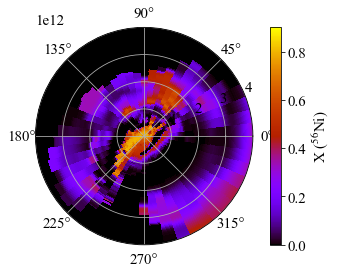

In [294]:
# plt.subplot(projection="polar")
# c_ = np.array(data_mesh_oplane["c66"]).reshape(100,50)
# plt.pcolormesh(phi_coord_w_edge, r_coord, c_, cmap="gnuplot", vmax=0.9)
# plt.grid()
# cb = plt.colorbar()
# cb.set_label(r"X ($^{56}$Ni)")
# plt.savefig("figs/hewd/slice_oplane_mesh.pdf", dpi=300, transparent=True)
# plt.show()

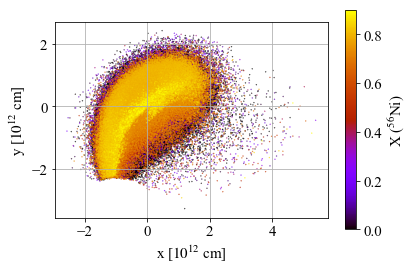

In [308]:
# sph_data_ = sph_data_unbound[np.abs(sph_data_unbound["c6"]) < 1e11]
sph_data_ = sph_data_unbound.sort_values("c99")
x_ = sph_data_["c101"] / 1e12
y_ = sph_data_["c102"] / 1e12
c_ = sph_data_["c99"]

fig = plt.figure()
plt.scatter(x_, y_, c=c_, s=0.1, cmap="gnuplot", marker="o", vmax=0.9)

cb = plt.colorbar()
cb.set_label(r"X ($^{56}$Ni)")
# plt.xlim(-4,4)
# plt.ylim(-4,4)
plt.xlabel(r"x [$10^{12}$ cm]")
plt.ylabel(r"y [$10^{12}$ cm]")
plt.gca().set_aspect("equal")
plt.grid()
fig.tight_layout()
plt.savefig("figs/hewd/sph_unoubnd.png", dpi=300, transparent=True)
plt.show()

# spectra

In [11]:
import matplotlib.colors as colors

In [54]:
# %time spectra = photontools.read_Maeda_data(filepath_he)

# # # Doppler shift
# %time spectra_shifted = spectra.Doppler_shift_by_intrinsic_velocity(vel_hewd)

# binning 
%time spectra_reduced = spectra.binning(N_theta_bins=1, N_phi_bins=1, every_wavelength=1)
# %time spectra_reduced = spectra.binning(N_theta_bins=20, N_phi_bins=20, every_wavelength=1)

CPU times: user 485 ms, sys: 295 ms, total: 780 ms
Wall time: 785 ms


In [53]:
%time spectra_ = spectra.binning(N_theta_bins=1, N_phi_bins=1, every_wavelength=1)

CPU times: user 1.1 s, sys: 3.1 s, total: 4.2 s
Wall time: 5.83 s


In [68]:
plt.rcParams["figure.dpi"]=100

In [67]:
plt.annotate?

0.0 2.5722131572296068
0.057692307692307696 2.953295842615305
0.11538461538461539 3.3908373065795203
0.17307692307692307 3.893202121433775
0.23076923076923078 4.469994101140162
0.28846153846153844 5.132239899445386
0.34615384615384615 5.892599808742626
0.40384615384615385 6.765609789547433
0.46153846153846156 7.767959357516133
0.5192307692307693 8.918810640431396
0.5769230769230769 10.240164704634536
0.6346153846153846 11.757282154044125
0.6923076923076923 13.499166042440912
0.75 15.499116330954891
0.8076923076923077 17.795366490435118
0.8653846153846154 20.43181441876376
0.9230769230769231 23.4588616462147
0.9807692307692307 25.703956403366202


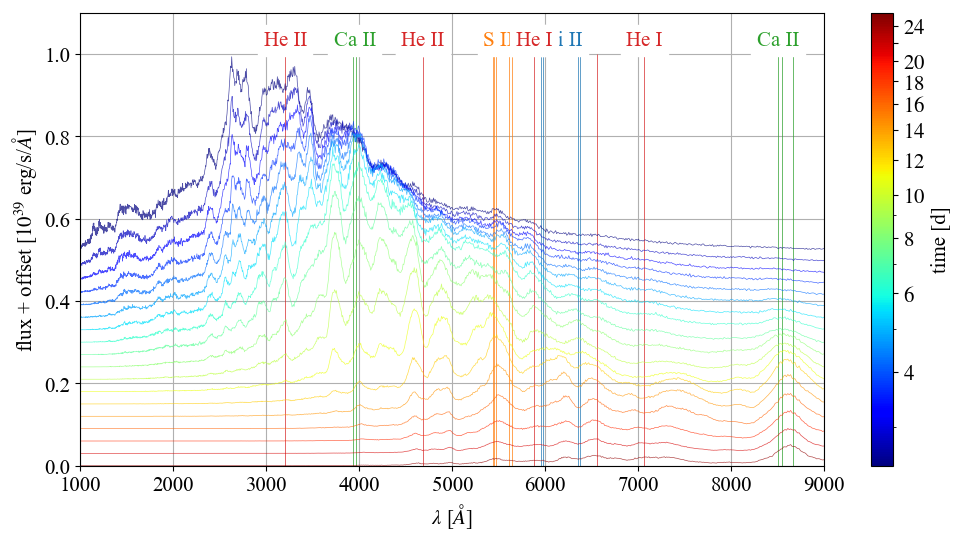

In [88]:
mycolor=plt.cm.jet
i_time=9
i_time_ed = -25
# i_time_ed = -1
# i_time=64
# i_time_ed = 66
j_theta=0
j_theta_ed=1
k_phi=0
k_phi_ed=1
every_time = 3

fig=plt.figure(figsize=(12,6))
# fig=plt.figure()
ax= plt.gca()

spectra_ = spectra_reduced[i_time:i_time_ed,j_theta:j_theta_ed,:]

offset_ = 0.01e39
for i_time in np.arange(0, spectra_.times.size, every_time):
    i_time_ed = i_time + every_time
#     offset_ = 0
    plt.plot(spectra_.wavelengths, (0.51e39 - offset_ * i_time + spectra_.data[i_time:i_time_ed,:,k_phi:k_phi_ed].mean(axis=(0,1,2))) / 1e39, 
             alpha=0.7, color=mycolor(i_time / spectra_.times.size), linewidth=0.5)
#     plt.plot(spectra_.wavelengths, (0.51e39 - offset_ * i_time + spectra_.data[i_time:i_time_ed,:,k_phi:k_phi_ed].mean(axis=(0,1,2))) / 1e39, 
#              alpha=0.7, color=mycolor(i_time / spectra_.times.size), linewidth=0.5)
#     plt.plot(spectra_.wavelengths, + - offset_ * i_time + spectra_.data[i_time:i_time_ed,:,k_phi:k_phi_ed].mean(axis=(0,1,2)), 
#              alpha=0.7, color=spectra_.times[i_time:i_time_ed].mean())
    print(i_time / spectra_.times.size, spectra_.times[i_time:i_time_ed].mean())

# for k_phi in range(spectra_.phis.size):
#     k_phi_ed = k_phi + 1
#     plt.plot(spectra_.wavelengths, spectra_.data[:,:,k_phi:k_phi_ed].mean(axis=(0,1,2)), 
#              alpha=0.7, color=mycolor(k_phi / spectra_.phis.size))
# plt.plot(spectra_.wavelengths, spectra_.data[:,:,:].mean(axis=(0,1,2)), 
#          alpha=0.7, color=mycolor(k_phi / spectra_.phis.size))

ymax=1
lines_name, lines_lambda = give_lines()
for i in range(lines_lambda.size):
    line_lambda = lines_lambda[i]
    line_name = lines_name[i]
#     if (i in [0, 5, 10]):
#         plot_one_line(fig, ax, line_lambda, 1.02, line_name, ymin=0, ymax=1, show_label=True,**keys_line)
#     else:
    plot_one_line(fig, ax, line_lambda, ymax, line_name, ymin=0, ymax=ymax, linewidth=0.5, show_label=False)

y_annot=1.02
ax.annotate("Si II" ,xy=(6200, y_annot), ha="center", backgroundcolor='white', color="C0")
ax.annotate("S II" ,xy=(5500, y_annot), ha="center", backgroundcolor='white', color="C1")
ax.annotate("Ca II" ,xy=(8500, y_annot), ha="center", backgroundcolor='white', color="C2")
ax.annotate("Ca II" ,xy=(3950, y_annot), ha="center", backgroundcolor='white', color="C2")
ax.annotate("He II" ,xy=(4686, y_annot), ha="center", backgroundcolor='white', color="C3")
ax.annotate("He II" ,xy=(3203, y_annot), ha="center", backgroundcolor='white', color="C3")
ax.annotate("He II" ,xy=(4686, y_annot), ha="center", backgroundcolor='white', color="C3")
ax.annotate("He I" ,xy=(5876, y_annot), ha="center", backgroundcolor='white', color="C3")
ax.annotate("He I" ,xy=(7065, y_annot), ha="center", backgroundcolor='white', color="C3")
# ax.annotate("He I" ,xy=(6560, y_annot), ha="center", backgroundcolor='white', color="C3")


# create a colorbar
# sm = plt.cm.ScalarMappable(cmap=mycolor, norm=plt.Normalize(vmin=spectra_.times.min(), vmax=spectra_.times.max()))
sm = plt.cm.ScalarMappable(cmap=mycolor, norm=colors.LogNorm(vmin=spectra_.times.min(), vmax=spectra_.times.max()))
sm._A = []
cb = plt.colorbar(sm,label=r'time [d]',orientation='vertical',shrink=1.0)
# cb = plt.colorbar(sm,label=r'Azimuthal Angle $\phi$ ',orientation='vertical',shrink=1.0)

myticks = np.arange(2.,25, 2.)
# myticks = np.linspace(0.,2.,9)*np.pi
mylabel = [r"${:d}$".format(int(i)) for i in np.arange(2.,22, 2.)]
mylabel.append("")
mylabel.append(r"$24$")
# mylabel = [r"$0$","",r"$\frac{\pi}{2}$","",r"$\pi$","",r"$\frac{3 \pi}{2}$","",r"$2 \pi$"]
cb.set_ticks(myticks)
cb.set_ticklabels(mylabel)

# plt.title(r"w/o Doppler shift, $t = {:.1f}$ d, $\cos\,\theta = {:.1f}$".format(spectra_.times.mean(), np.abs(np.cos(spectra_.thetas[:-1].mean()))))
# plt.title(r"w/o Doppler shift, mean over all the angle")
# plt.title(r"$t = {:.0f}$ d, $\theta = {:.2f}$".format(spectra_.times[i_time:i_time_ed].mean(), spectra_.thetas[j_theta:j_theta_ed].mean()))
# plt.title(r"$t = {:.1f}$ d, $\theta = {:.2f}$, $\phi = {:.2f}$".format(spectra_.times[i_time:i_time_ed].mean(), spectra_.thetas[j_theta:j_theta_ed].mean(), spectra_.phis[k_phi:k_phi_ed].mean()))
plt.xlabel(r"$\lambda$ [$\AA$]")
plt.ylabel(r"flux + offset [$10^{39}$ erg/s/$\AA$]")
plt.xlim(1000, 9000)
plt.ylim(0,1.1)

plt.grid()

# plt.savefig("figs/hewd/spectra_t{:.0f}.png".format(spectra_.times[i_time:i_time_ed].mean()))
# plt.savefig("figs/hewd/spectra_wo_Doppler_shift_all_angle.pdf", dpi=300, transparent=True)
plt.show()


In [79]:
def give_lines():
    lines_CaII = np.array([3933.66, 3968.47, 8498.02, 8542.09, 8662.14])
    lines_SII = np.array([5432.80, 5453.85, 5473.61, 5606.15, 5640.35])
    lines_SiII = np.array([5957.56, 5978.93, 6347.11, 6371.37])
    lines_HeII = np.array([3203, 4686, 6560])
    lines_HeI = np.array([5876, 7065])
    line_names = ["Ca II", "S II", "Si II", "He II", "He I"]
#     print(np.array(line_names[3] * lines_HeII.size)
    line_names = np.concatenate([np.array([line_names[0]] * lines_CaII.size), 
                                 np.array([line_names[1]] * lines_SII.size), 
                                 np.array([line_names[2]] * lines_SiII.size), 
                                 np.array([line_names[3]] * lines_HeII.size), 
                                 np.array([line_names[4]] * lines_HeI.size)])
    lines_lambda = np.concatenate([lines_CaII, lines_SII, lines_SiII, lines_HeII, lines_HeI])
    return line_names, lines_lambda

def plot_one_line(fig, ax, x, y, name=None, ymin=None, ymax=None, show_label=False, **keys):
    color_dict={"None": "black", "Si": "C0", "S": "C1", "Ca":"C2", "He":"C3"}
    exclude_lines_show_name = np.array([3933.66, 8498.02, 8662.14, 5432.80, 5473.61, 5606.15, 5957.56, 6347.11])
    show_elements = np.array(["Si", "S", "Ca", "He"])
    if name is None:
        element = "None"
    else:
        element = name.split(" ")[0].split("[")[0]

    if ymin is None:
        ymin = ax.get_ylim()[0]
    if ymax is None:
        ymax = ax.get_ylim()[1]

    if (show_label):
        label=name
    else:
        label=""
    if (np.sum(element == show_elements) > 0):
        ax.vlines(x, ymin, ymax, color=color_dict[element], label=label, **keys)
#         if (np.sum(x == exclude_lines_show_name) == 0):
#             print(x, name, x == exclude_lines_show_name)
#             ax.annotate(name ,xy=(x, y), ha="center", backgroundcolor='white', color=color_dict[element])
#         ax.annotate(name ,xy=(x, 0.92 * ax.get_ylim()[1]), color='Black', ha="center")
        

In [29]:

# around t= 10
i_time=43
i_time_ed = 54
j_theta = 5
j_theta_ed = 15
l_wava = 2000
l_wava_ed = 2160
# l_wava = 2060
# l_wava_ed = 2100
# l_wava = 2120
# l_wava_ed = 2200
mask = (spectra_reduced.wavelengths <  9200) * (spectra_reduced.wavelengths >  8000)
mask

spectra_ = spectra_reduced[i_time:i_time_ed, :, :,mask]
# spectra_center = give_lines()[1][1]
spectra_center = 8600
vel_array = (1. - spectra_.wavelengths / spectra_center) * c.c.cgs.value / 1e5
spectra_.times, spectra_.times.mean()

(array([11.7489751 , 12.30268723, 12.882495  , 13.48962827, 14.12537485,
        14.79108324, 15.48816551, 16.21810024, 16.98243574, 17.78279326,
        18.62087047]), 14.94841899313243)

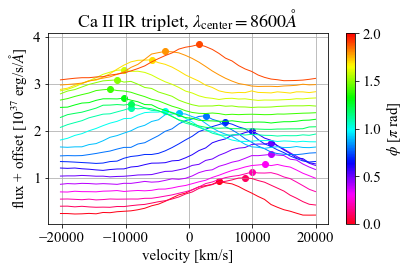

In [215]:
mycolor=plt.cm.hsv_r
# mycolor=plt.cm.viridis
j_theta=0
j_theta_ed=4
k_phi=0
k_phi_ed=20
every_phi = 1
keys_line ={"linewidth":0.5}


# fig = plt.figure(figsize=(16,8))
fig = plt.figure(figsize=(6,4))
ax = plt.gca()

for k_phi in np.arange(0, spectra_.phis.size, every_phi):
    k_phi_ed = k_phi + every_phi
    offset_ = - 0.015e39
    offset_2 = 20 * offset_
    offset_2 = 0
#     offset_ = 0
    plt.plot(vel_array, (offset_2 - offset_ * k_phi + spectra_.data[:,:,k_phi:k_phi_ed].mean(axis=(0,1,2))) / 1e38, 
             alpha=1, linewidth=1, color=mycolor(k_phi / spectra_.phis.size))
    l_max = np.argmax(spectra_.data[:,:,k_phi:k_phi_ed].mean(axis=(0,1,2)))
    plt.scatter(vel_array[l_max], (offset_2 - offset_ * k_phi + spectra_.data[:,:,k_phi:k_phi_ed, l_max].mean(axis=(0,1,2))) / 1e38, 
             alpha=1, marker="o", color=mycolor(k_phi / spectra_.phis.size))
#     plt.plot(spectra_.wavelengths, (offset_2 - offset_ * k_phi + spectra_.data[:,:,k_phi:k_phi_ed].mean(axis=(0,1,2))) / 1e39, 
#              alpha=1, linewidth=0.5, color=mycolor(k_phi / spectra_.phis.size))
#     plt.plot(spectra_.wavelengths, + - offset_ * i_time + spectra_.data[i_time:i_time_ed,:,k_phi:k_phi_ed].mean(axis=(0,1,2)), 
#              alpha=1, color=spectra_.times[i_time:i_time_ed].mean())


# lines_name, lines_lambda = give_lines()
# for i in range(lines_lambda.size):
#     line_lambda = lines_lambda[i]
#     line_name = lines_name[i]
# #     if (i in [0, 5, 10]):
# #         plot_one_line(fig, ax, line_lambda, 1.02, line_name, ymin=0, ymax=1, show_label=True,**keys_line)
# #     else:
#     plot_one_line(fig, ax, line_lambda, 1.02, line_name, ymin=0, ymax=1, show_label=False,**keys_line)

# ax.annotate("Si II" ,xy=(6200, 0.95), ha="center", backgroundcolor='white', color="C0")
# ax.annotate("S II" ,xy=(5500, 0.95), ha="center", backgroundcolor='white', color="C1")
# ax.annotate("Ca II" ,xy=(8500, 0.95), ha="center", backgroundcolor='white', color="C2")
# ax.annotate("Ca II" ,xy=(3950, 0.95), ha="center", backgroundcolor='white', color="C2")

# for k_phi in range(spectra_.phis.size):
#     k_phi_ed = k_phi + 1
#     plt.plot(spectra_.wavelengths, spectra_.data[:,:,k_phi:k_phi_ed].mean(axis=(0,1,2)), 
#              alpha=1, color=mycolor(k_phi / spectra_.phis.size))
# plt.plot(spectra_.wavelengths, spectra_.data[:,:,:].mean(axis=(0,1,2)), 
#          alpha=1, color=mycolor(k_phi / spectra_.phis.size))


# create a colorbar
# sm = plt.cm.ScalarMappable(cmap=mycolor, norm=plt.Normalize(vmin=spectra_.times.min(), vmax=spectra_.times.max()))
sm = plt.cm.ScalarMappable(cmap=mycolor, norm=colors.Normalize(vmin=0, vmax=2))
sm._A = []
cb = plt.colorbar(sm,label=r'$\phi$ [$\pi$ rad]',orientation='vertical',shrink=1.0)
# cb = plt.colorbar(sm,label=r'Azimuthal Angle $\phi$ ',orientation='vertical',shrink=1.0)

# myticks = np.arange(0., 2.5, 0.5)
# myticks = np.linspace(0.,2.,9)
# mylabel = [r"${:.1f}$".format(i) for i in np.linspace(0.,2.,9)]
# mylabel = [r"$0$","",r"$\frac{\pi}{2}$","",r"$\pi$","",r"$\frac{3 \pi}{2}$","",r"$2 \pi$"]
# cb.set_ticks(myticks)
# cb.set_ticklabels(mylabel)

# plt.title(r"w/o Doppler shift, $t = {:.1f}$ d, $\cos\,\theta = {:.1f}$".format(spectra_.times.mean(), np.abs(np.cos(spectra_.thetas[:-1].mean()))))
# plt.title(r"w/o Doppler shift, mean over all the angle")
# plt.title(r"$t = {:.0f}$ d, $\theta = {:.2f}$".format(spectra_.times[i_time:i_time_ed].mean(), spectra_.thetas[j_theta:j_theta_ed].mean()))
# plt.title(r"$t = {:.1f}$ d, $\theta = {:.2f}$, $\phi = {:.2f}$".format(spectra_.times[i_time:i_time_ed].mean(), spectra_.thetas[j_theta:j_theta_ed].mean(), spectra_.phis[k_phi:k_phi_ed].mean()))
plt.xlabel(r"velocity [km/s]")
plt.ylabel(r"flux + offset [$10^{37}$ erg/s/$\AA$]")
# plt.xlim(1000, 9000)

plt.grid()
plt.title(r"Ca II IR triplet, $\lambda_{\rm center} = 8600 \AA$")
# plt.legend(loc="best")
fig.tight_layout()
# plt.savefig("figs/hewd/spectra_vel_CaII_t{:.0f}.pdf".format(spectra_.times.mean()), dpi=300, transparent=True)
# plt.savefig("figs/hewd/spectra_wo_Doppler_shift_all_angle2.pdf", dpi=300, transparent=True)

plt.show()



In [214]:
spectra_.times[i_time:i_time_ed]

array([], dtype=float64)

In [421]:
spectra_reduced_high.data.shape

(71, 10, 10, 600)

In [423]:
spectra_.data.shape

(76, 5, 1, 3000)

<IPython.core.display.Javascript object>


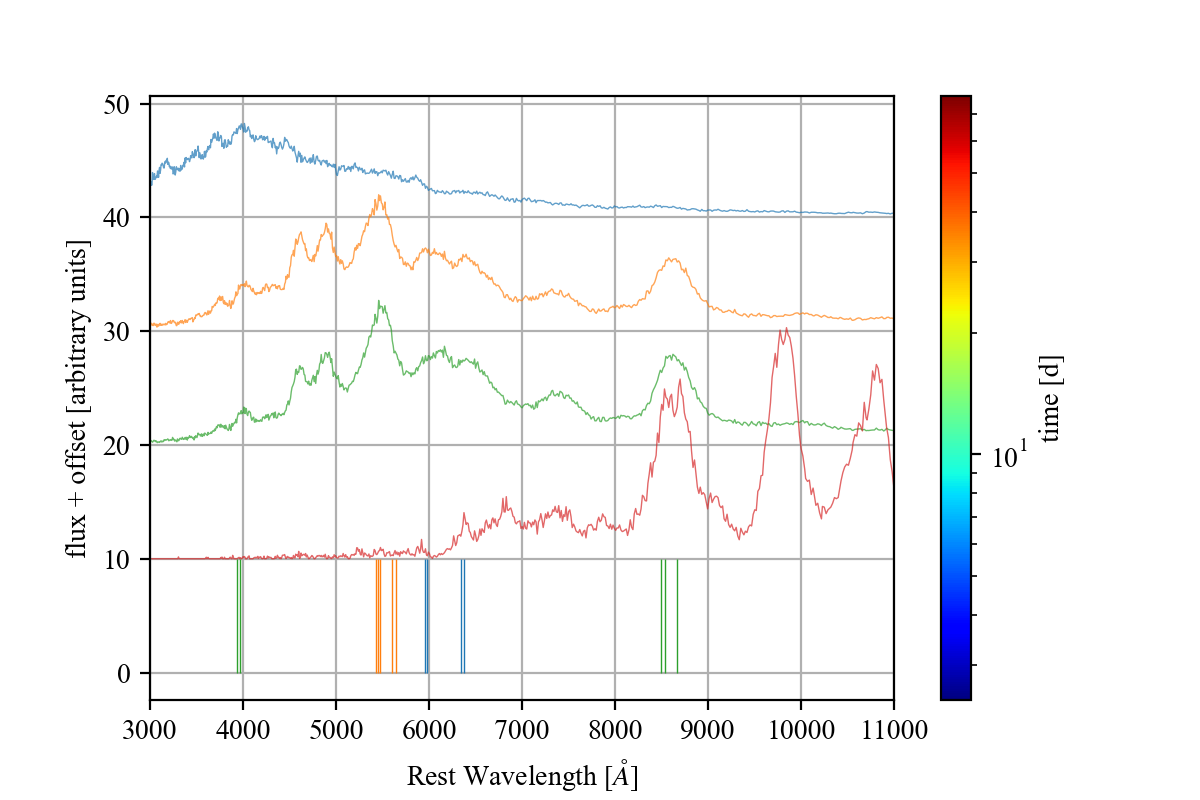

1.0
0.17105263157894737 4.680658428105014
1.0000000000000002
0.4473684210526316 12.311385778316428
0.9999999999999997
0.47368421052631576 13.499166042440912
0.9999999999999999
0.8552631578947368 51.32239635305492


In [433]:
mycolor=plt.cm.jet
i_time=9
# i_time_ed = -25
i_time_ed = -1
# i_time=64
# i_time_ed = 66
j_theta=5
j_theta_ed=15
k_phi=9
k_phi_ed=11
every_time = 3

offset2_ = 40
offset_ = 10
spectra_ = spectra_reduced[i_time:i_time_ed,j_theta:j_theta_ed,k_phi:k_phi_ed]


fig=plt.figure()
ax = plt.gca()

i_time_arr = np.array([13, 34, 36, 65])
for i, i_time in enumerate(i_time_arr):
    i_time_ed = i_time + every_time
    i_time_st = i_time - every_time
#     offset_ = 0
    data_ = spectra_.data[i_time_st:i_time_ed,:,:].mean(axis=(0,1,2))
    data_ = data_ / data_.mean()
    plt.plot(spectra_.wavelengths, (offset2_ - offset_ * i + data_), 
             alpha=0.7, linewidth=0.5, color="C{:1d}".format(i))
    print(data_.mean())
#     plt.plot(spectra_.wavelengths, + - offset_ * i_time + spectra_.data[i_time:i_time_ed,:,k_phi:k_phi_ed].mean(axis=(0,1,2)), 
#              alpha=0.7, color=spectra_.times[i_time:i_time_ed].mean())
    print(i_time / spectra_.times.size, spectra_.times[i_time:i_time_ed].mean())

# for k_phi in range(spectra_.phis.size):
#     k_phi_ed = k_phi + 1
#     plt.plot(spectra_.wavelengths, spectra_.data[:,:,k_phi:k_phi_ed].mean(axis=(0,1,2)), 
#              alpha=0.7, color=mycolor(k_phi / spectra_.phis.size))
# plt.plot(spectra_.wavelengths, spectra_.data[:,:,:].mean(axis=(0,1,2)), 
#          alpha=0.7, color=mycolor(k_phi / spectra_.phis.size))


lines_name, lines_lambda = give_lines()
for i in range(lines_lambda.size):
    line_lambda = lines_lambda[i]
    line_name = lines_name[i]
#     if (i in [0, 5, 10]):
#         plot_one_line(fig, ax, line_lambda, 1.02, line_name, ymin=0, ymax=1, show_label=True,**keys_line)
#     else:
    plot_one_line(fig, ax, line_lambda, 90, line_name, ymin=0, ymax=10, linewidth=0.5, show_label=False)

ax.annotate("Si II" ,xy=(6200, 80), ha="center", backgroundcolor='white', color="C0")
ax.annotate("S II" ,xy=(5500, 80), ha="center", backgroundcolor='white', color="C1")
ax.annotate("Ca II" ,xy=(8500, 80), ha="center", backgroundcolor='white', color="C2")
ax.annotate("Ca II" ,xy=(3950, 80), ha="center", backgroundcolor='white', color="C2")



# create a colorbar
# sm = plt.cm.ScalarMappable(cmap=mycolor, norm=plt.Normalize(vmin=spectra_.times.min(), vmax=spectra_.times.max()))
sm = plt.cm.ScalarMappable(cmap=mycolor, norm=colors.LogNorm(vmin=spectra_.times.min(), vmax=spectra_.times.max()))
sm._A = []
cb = plt.colorbar(sm,label=r'time [d]',orientation='vertical',shrink=1.0)
# cb = plt.colorbar(sm,label=r'Azimuthal Angle $\phi$ ',orientation='vertical',shrink=1.0)





# myticks = np.arange(2.,25, 2.)
# # myticks = np.linspace(0.,2.,9)*np.pi
# mylabel = [r"${:d}$".format(int(i)) for i in np.arange(2.,22, 2.)]
# mylabel.append("")
# mylabel.append(r"$24$")
# # mylabel = [r"$0$","",r"$\frac{\pi}{2}$","",r"$\pi$","",r"$\frac{3 \pi}{2}$","",r"$2 \pi$"]
# cb.set_ticks(myticks)
# cb.set_ticklabels(mylabel)

# plt.title(r"w/o Doppler shift, $t = {:.1f}$ d, $\cos\,\theta = {:.1f}$".format(spectra_.times.mean(), np.abs(np.cos(spectra_.thetas[:-1].mean()))))
# plt.title(r"w/o Doppler shift, mean over all the angle")
# plt.title(r"$t = {:.0f}$ d, $\theta = {:.2f}$".format(spectra_.times[i_time:i_time_ed].mean(), spectra_.thetas[j_theta:j_theta_ed].mean()))
# plt.title(r"$t = {:.1f}$ d, $\theta = {:.2f}$, $\phi = {:.2f}$".format(spectra_.times[i_time:i_time_ed].mean(), spectra_.thetas[j_theta:j_theta_ed].mean(), spectra_.phis[k_phi:k_phi_ed].mean()))
# plt.legend()
plt.xlabel(r"Rest Wavelength [$\AA$]")
plt.ylabel(r"flux + offset [arbitrary units]")
# plt.ylabel(r"flux + offset [$10^{39}$ erg/s/$\AA$]")
plt.xlim(3000, 11000)

plt.grid()
# plt.savefig("figs/hewd/spectra_t{:.0f}.png".format(spectra_.times[i_time:i_time_ed].mean()))
# plt.savefig("figs/hewd/spectra_wo_Doppler_shift_all_angle.pdf", dpi=300)
# plt.show()



In [428]:
%matplotlib notebook
plt.rcParams["figure.dpi"] = 100


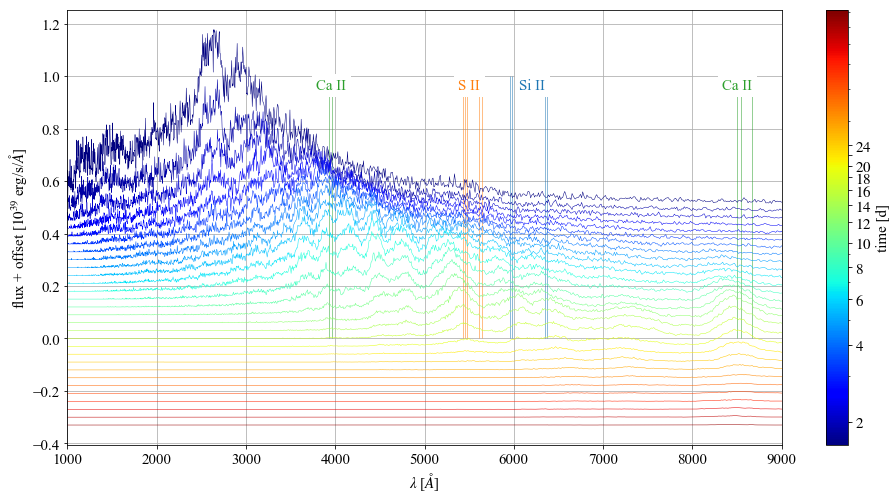

In [40]:
mycolor=plt.cm.jet
i_time=-30
i_time_ed = -1
# i_time=64
# i_time_ed = 66
j_theta=0
j_theta_ed=1
k_phi=0
k_phi_ed=1
every_time = 3
keys_line ={"linewidth":0.5}



fig = plt.figure(figsize=(16,8))
# fig = plt.figure(figsize=(6,4))
ax = plt.gca()
# mycolor=plt.cm.viridis

# spectra_ = spectra_reduced[i_time:i_time_ed,j_theta:j_theta_ed,k_phi:k_phi_ed]
# spectra_ = spectra_reduced[i_time:i_time_ed,j_theta:j_theta_ed,:]
# %time spectra__ = spectra.binning(N_theta_bins=1, N_phi_bins=1, every_wavelength=1)
# spectra_=spectra__[i_time:i_time_ed]
# for i_time in np.arange(0, spectra_.times.size, every_time):
for i_time in np.arange(40, spectra_.times.size, every_time):
    i_time_ed = i_time + every_time
    offset_ = 0.01e39
#     offset_ = 0
    plt.plot(spectra_.wavelengths, (0.51e39 - offset_ * i_time + spectra_.data[i_time:i_time_ed,:,k_phi:k_phi_ed].mean(axis=(0,1,2))) / 1e39, 
             alpha=0.7, linewidth=0.5, color=mycolor(i_time / spectra_.times.size))
#     plt.plot(spectra_.wavelengths, + - offset_ * i_time + spectra_.data[i_time:i_time_ed,:,k_phi:k_phi_ed].mean(axis=(0,1,2)), 
#              alpha=0.7, color=spectra_.times[i_time:i_time_ed].mean())


lines_name, lines_lambda = give_lines()
for i in range(lines_lambda.size):
    line_lambda = lines_lambda[i]
    line_name = lines_name[i]
#     if (i in [0, 5, 10]):
#         plot_one_line(fig, ax, line_lambda, 1.02, line_name, ymin=0, ymax=1, show_label=True,**keys_line)
#     else:
    plot_one_line(fig, ax, line_lambda, 1.02, line_name, ymin=0, ymax=1, show_label=False,**keys_line)

ax.annotate("Si II" ,xy=(6200, 0.95), ha="center", backgroundcolor='white', color="C0")
ax.annotate("S II" ,xy=(5500, 0.95), ha="center", backgroundcolor='white', color="C1")
ax.annotate("Ca II" ,xy=(8500, 0.95), ha="center", backgroundcolor='white', color="C2")
ax.annotate("Ca II" ,xy=(3950, 0.95), ha="center", backgroundcolor='white', color="C2")

# for k_phi in range(spectra_.phis.size):
#     k_phi_ed = k_phi + 1
#     plt.plot(spectra_.wavelengths, spectra_.data[:,:,k_phi:k_phi_ed].mean(axis=(0,1,2)), 
#              alpha=0.7, color=mycolor(k_phi / spectra_.phis.size))
# plt.plot(spectra_.wavelengths, spectra_.data[:,:,:].mean(axis=(0,1,2)), 
#          alpha=0.7, color=mycolor(k_phi / spectra_.phis.size))


# create a colorbar
# sm = plt.cm.ScalarMappable(cmap=mycolor, norm=plt.Normalize(vmin=spectra_.times.min(), vmax=spectra_.times.max()))
sm = plt.cm.ScalarMappable(cmap=mycolor, norm=colors.LogNorm(vmin=spectra_.times.min(), vmax=spectra_.times.max()))
sm._A = []
cb = plt.colorbar(sm,label=r'time [d]',orientation='vertical',shrink=1.0)
# cb = plt.colorbar(sm,label=r'Azimuthal Angle $\phi$ ',orientation='vertical',shrink=1.0)

myticks = np.arange(2.,25, 2.)
# myticks = np.linspace(0.,2.,9)*np.pi
mylabel = [r"${:d}$".format(int(i)) for i in np.arange(2.,22, 2.)]
mylabel.append("")
mylabel.append(r"$24$")
# mylabel = [r"$0$","",r"$\frac{\pi}{2}$","",r"$\pi$","",r"$\frac{3 \pi}{2}$","",r"$2 \pi$"]
cb.set_ticks(myticks)
cb.set_ticklabels(mylabel)

# plt.title(r"w/o Doppler shift, $t = {:.1f}$ d, $\cos\,\theta = {:.1f}$".format(spectra_.times.mean(), np.abs(np.cos(spectra_.thetas[:-1].mean()))))
# plt.title(r"w/o Doppler shift, mean over all the angle")
# plt.title(r"$t = {:.0f}$ d, $\theta = {:.2f}$".format(spectra_.times[i_time:i_time_ed].mean(), spectra_.thetas[j_theta:j_theta_ed].mean()))
# plt.title(r"$t = {:.1f}$ d, $\theta = {:.2f}$, $\phi = {:.2f}$".format(spectra_.times[i_time:i_time_ed].mean(), spectra_.thetas[j_theta:j_theta_ed].mean(), spectra_.phis[k_phi:k_phi_ed].mean()))
plt.xlabel(r"$\lambda$ [$\AA$]")
plt.ylabel(r"flux + offset [$10^{39}$ erg/s/$\AA$]")
plt.xlim(1000, 9000)

plt.grid()
# plt.legend(loc="best")
# fig.tight_layout()
# plt.savefig("figs/hewd/spectra_t{:.0f}.png".format(spectra_.times[i_time:i_time_ed].mean()))
# plt.savefig("figs/hewd/spectra_wo_Doppler_shift_all_angle2.pdf", dpi=300, transparent=True)

# plt.show()

